In [427]:
import re
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lmfit import Model
from numpy import exp, loadtxt, pi, sqrt, std, mean, add
import scipy
import scikits.bootstrap as bootstrap
from statistics import stdev 
from scipy import stats
import scipy.special as sps

### Parameters

In [428]:
#### change path here
#path = "/Users/mauromanassi/Dropbox/Cristina Radiologist/Data_Analyze/data/Radiologists/" # must have "/" at the end
path = os.getcwd()
path = path + "/"

#### User's Input
halfway = 90 # circular space correction 74for morphs
step = 15 # for running mean, how wide to run avg.
nBack = 1 # how many trials to go back/forward if+ 1Back if- 1Forward

timecutoff = 200 # if exceeds this RT, then filtered
ErrorCutoff = 40 # for error (bar - gabor) filter
SDcutoffYN = 0
polynum = 8 # polynomial correction, highest exponent

#### DoG Parameters
guessA = 6 # DoG, a
guessB = 0.03 # 0.03 DoG, b guess (different meaning from b in graph, here's math one, in graph is width)
a_constraint = 40 # constraint -- max of a in fitting process
a_constraint_min = -40
b_constraint = 40 # constraint -- max of a in fitting process
b_constraint_min = -40

#### Control console
TimelimitYN = 1 # remove over-RT?
FilterYN = 1 # Filter?
polyYN = 0 # do polynomial correction?
DoGYN = 1 # plot DoG curve?
bootstrapYN = 0 # do bootstrap sampling?
permYN = 0 # do permutation sampling?

IterBoot = 5000
bsSize = IterBoot
IterPerm = 5000
permSize = IterPerm


### Looks For Files In Folder

In [429]:
##### read all csv files
files = os.listdir(path)
files_csv = list(filter(lambda x: x[-4:] == '.csv' , files))

FileNameList = []
for file in files_csv:
    FileName = file[-7:-4]
    FileNameList.append(FileName)

##### if result exists, don't run function again
ResultPath = path + 'results/'

##### show files to analyze
print('FILES:')
print(files_csv)

FILES:
['AS_SD_Long_2020_Feb_10_1241.csv']


### Data Assembling

In [430]:
# define a void list to store data
data_list = []

# transformation
num_filter = re.compile(r'\d+')

#read useful columns, save in data_list
for file in  files_csv:
    tmp = (pd.read_csv(path + file)[['Gabor_Orient', 'AdjResp', 'AdjTime', 'trialsLoop.thisRepN', 'blocksLoop.thisRepN']])
    data_list.append(tmp)
# cat all datas
all_data_with_training = pd.concat(data_list)
all_data_with_training.head()

# removing training blocks
#all_data = all_data_with_training[all_data_with_training['blockType'] != 'training']
all_data = all_data_with_training

# computes trial number per block, block number and total trial number
subjects = len(files_csv) #only for online studies
blocks = (np.nanmax(all_data['blocksLoop.thisRepN']))+1 #+1 because it starts at 0
trials = (np.nanmax(all_data['trialsLoop.thisRepN']))+1 #+1 because it starts at 0
TotalTrial = blocks * trials
print(subjects,'subject(s).',blocks,'blocks.', trials,'trials/blocks.', TotalTrial,'total trials.')
    
# delete invalid rows and useless columns
all_data.dropna(axis = 0, how = 'any', inplace = True) # exclude NaN (often between blocks)
plot_data = all_data.reset_index() #re-index and deleted unnecessary columns
del plot_data['index']


1 subject(s). 4.0 blocks. 100.0 trials/blocks. 400.0 total trials.


### X-axis and Y-axis plotting

In [431]:

# make xdata(x) and ydata(y) into list
xdata = []
ydata = []
zdata = []
PreStim = []
CurrStim = []
PreResp = []
CurrResp = []

for i in np.arange(blocks): #all blocks 8
    for e in np.arange(trials-nBack): #all trials
        if (plot_data['AdjTime'][e+1])<timecutoff: # time cutoff
            #if ((plot_data['RespORIis'][e]==1) and (plot_data['RespORIis'][e+nBack]==1)) or ((plot_data['RespORIis'][e]==0) and (plot_data['RespORIis'][e+nBack]==1)):
            #if ((plot_data['RespORIis'][e]==1) and (plot_data['RespORIis'][e+nBack]==1)):
            #if ((plot_data['RespORIis'][e]==0) and (plot_data['RespORIis'][e+nBack]==1)):
        

                #PreStim = np.concatenate((PreStim, (plot_data['stimOrientation'][e+(trials*i)])), axis=None)
                #CurrStim = np.concatenate((CurrStim, (plot_data['stimOrientation'][(e+1)+(trials*i)])), axis=None)
                #PreResp = np.concatenate((PreResp, (plot_data['BioResp'][e+(trials*i)])), axis=None)
                #CurrResp = np.concatenate((CurrResp, (plot_data['BioResp'][(e+1)+(trials*i)])), axis=None)

                PreStim.append(plot_data.loc[(plot_data['trialsLoop.thisRepN'] == e) & (plot_data['blocksLoop.thisRepN'] == i)]['Gabor_Orient'].values[0])
                CurrStim.append(plot_data.loc[(plot_data['trialsLoop.thisRepN'] == e+nBack) & (plot_data['blocksLoop.thisRepN'] == i)]['Gabor_Orient'].values[0])
                PreResp.append(plot_data.loc[(plot_data['trialsLoop.thisRepN'] == e) & (plot_data['blocksLoop.thisRepN'] == i)]['AdjResp'].values[0])
                CurrResp.append(plot_data.loc[(plot_data['trialsLoop.thisRepN'] == e+nBack) & (plot_data['blocksLoop.thisRepN'] == i)]['AdjResp'].values[0])

xdata = np.array(PreStim)-np.array(CurrStim) # RELATIVE ORIENTATION
ydata = np.array(CurrResp)-np.array(CurrStim) # ERROR
CurrStim = np.array(CurrStim)

# adjust degree (-90~89 in this exp)
for i in range(0,len(xdata)):
    while xdata[i] > halfway - 1:
        xdata[i] = xdata[i] - 2 * halfway
    while xdata[i] < -halfway:
        xdata[i] = xdata[i] + 2 * halfway

    while ydata[i] > halfway - 1:
        ydata[i] = ydata[i] - 2 * halfway
    while ydata[i] < -halfway:
        ydata[i] = ydata[i] + 2 * halfway
    
# Filter for outliers in error(ydata)
if SDcutoffYN:
    ErrorCutoff = 2 * std(ydata)    
if FilterYN == 1:
    xdata = xdata[abs(ydata) < ErrorCutoff]
    CurrStim = CurrStim[abs(ydata) < ErrorCutoff]
    ydata = ydata[abs(ydata) < ErrorCutoff]
    print("Response Error SD =",round(ErrorCutoff / 3,2), ",",TotalTrial - len(ydata),"trials removed")

print("Response Error SD =",stdev(ydata))


# POLYNOMIAL CORRECTION
if polyYN == 1:
    coefs = np.polyfit(CurrStim, ydata, polynum) # polynomial coefs
    error_before_poly = ydata # original ydata (for plot)
    PolyLine = np.polyval(coefs, np.array(range(-halfway,halfway+1))) # continuous line (for plot)
    corrected_part = np.polyval(coefs, CurrStim) # generated new data (for plot and subtraction)
    ydata = ydata - corrected_part

    # poly fig
    plt.axis([-halfway, halfway, -40, 40])
    plt.plot(xdata, error_before_poly, 'bo', label='before poly')
    plt.plot(np.array(range(-halfway, halfway + 1)), PolyLine, label = 'poly', color = 'r', linewidth = 3)
    plt.plot(xdata, corrected_part, 'bo', label = 'polyval', color = 'g', linewidth = 3)
    title = "Polynomial Correction"
    plt.title(title, fontsize = 20)
    plt.xlabel("Current Shape Morph", fontsize = 15)
    plt.ylabel("Error", fontsize = 15)
    plt.tick_params(labelsize = 15)
    plt.legend()
    plt.show()
    plt.clf()
            

Response Error SD = 13.33 , 4.0 trials removed
Response Error SD = 13.581511487670758


### More Complex Stuff

In [432]:
#compensates for biases
ydata = ydata-np.mean(ydata)

# RUNNING MEAN
RM = [None] * (2 * halfway + 1); # running mean initialization
xvals = list(range(-halfway, halfway + 1)) # index for running mean -90~90 + -90~90 (avoid error in sep[jj] == 91\92...)
allx_vals = xvals + xvals
for ii in range(0,len(xvals) - 1): # start running mean calculation 0~180
    if ii - step // 2 >= 0:
        sep = allx_vals[(ii - step // 2) : (ii + step // 2 + 1)] # symmetric to avoid shift
    else:
        sep = allx_vals[(ii - step // 2) : len(allx_vals)] + allx_vals[0 : (ii + step // 2 + 1)]
    sep_sum = []
    for jj in range(0,len(sep)): # match every value in sep to every xdata point
        for kk in range(0, len(xdata)):
            if xdata[kk] == sep[jj]:
                sep_sum.insert(0, ydata[kk])
    RM[ii] = np.mean(sep_sum)
RM[2 * halfway] = RM[0]

# DoG FUNCTION
c = sqrt(2)/exp(-.5) # DoG param c
def gaussian(xdata, a = guessA, b = guessB):
    """1st order derivative gaussian: gaussian(xdata, a (peak to zero), b (0 to peak->x))"""
    return (a * b * c * xdata * exp(-((b * xdata) ** 2))) # Derivative of Gaussian formula

# Fitting
gmodel = Model(gaussian) # implement the model into this gmodel toolbox
gmodel.set_param_hint('a', max = a_constraint)
gmodel.set_param_hint('a', min = a_constraint_min)
gmodel.set_param_hint('b', max = b_constraint)
gmodel.set_param_hint('b', min = b_constraint_min)
result = gmodel.fit(ydata, xdata = xdata, b = guessB) # from this toolbox get the result

# print output a and b
best_values = result.best_values
a = best_values['a'] # get best_values a

# Sort to prepare plot
sorted_indices = np.argsort(xdata)
xdata = xdata[sorted_indices]
ydata = ydata[sorted_indices]
result.best_fit = result.best_fit[sorted_indices]

# get peak index and process width (b)
bIndex = np.where(result.best_fit == np.max(result.best_fit)) # fit peak, get index and put it in xdata to get b
bIndex = round(mean(bIndex))
b = xdata[int(bIndex)]
print("Amplitude =",round(a,2),"Width =",b) # print best output


Amplitude = 2.81 Width = 11.0


### Plotting

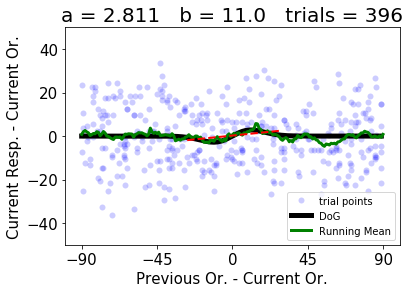

<Figure size 432x288 with 0 Axes>

In [433]:
fig1 = plt.gcf()

plt.axis([-100, 100, -50, 50])
plt.xticks(np.arange(-90, 90+1, 45))

plt.plot(xdata, ydata, 'bo', label = 'trial points', alpha = 0.2, markerfacecolor='blue',markeredgecolor='white',markeredgewidth=0)
if DoGYN == 1:
    plt.plot(xdata, result.best_fit, 'r-', label = 'DoG', color = 'k', linewidth = 5)
    f=(np.argmin(result.best_fit)) #19 max
    #print(f)
    #print(xdata[f])
plt.plot(xvals, RM, label = 'Running Mean', color = 'g', linewidth = 3)
title = "a = " + str(round(a, 3)) + "   b = " + str(round(b, 3)) + "   trials = " + str(len(xdata))
plt.title(title, fontsize = 20)
plt.xlabel("Previous Or. - Current Or.", fontsize = 15)
plt.ylabel("Current Resp. - Current Or.", fontsize = 15)
plt.tick_params(labelsize = 15)
plt.legend()
    
# Linear Regression Plot
IndexLocation2 = (np.logical_and(xdata > -29+1, xdata < 29+1)) #if ALL 46
ydata2 = ydata[IndexLocation2] # desired output is ['o','o','a']
xdata2 = xdata[IndexLocation2] # desired output is ['o','o','a']
    
m,b = np.polyfit(xdata2, ydata2, 1)
coef = np.polyfit(xdata2,ydata2,1)
poly1d_fn = np.poly1d(coef)
plt.plot(xdata2, poly1d_fn(xdata2), '--r', linewidth = 2)
#print(m,b)
    
    
plt.show()
FigName = path + 'Graph1.png'

fig1.tight_layout()
fig1.savefig(FigName, dpi=600)

plt.clf()

### BOOTSTRAP and PERMUTATION

In [435]:

# used for faster bootstrap and permutation
def CurvefitFunc(xdataNEW,ydataNEW):
    result = gmodel.fit(ydataNEW, xdata = xdataNEW, a = guessA, b = guessB)
    best_values = result.best_values
    a = best_values['a'] # get best_values a
    b = best_values['b'] # get best_values b
    return(a,b)

# BOOTSTRAP
if bootstrapYN == 1:
    print('BOOTSTRAP')
    # bs_a, bs_b = repeate_sampling('bs', xdata, ydata, CurvefitFunc, size = bsSize)
    OutA = np.empty(bsSize) # Output a array, store each trial's a
    OutB = np.empty(bsSize) # Output b array, store each trial's b
    for i in range(bsSize):
        RandIndex = np.random.randint(len(xdata), size = len(xdata)) # get randi index of xdata
        xdataNEW = xdata[RandIndex] # change xdata index
        ydataNEW = ydata[RandIndex] # change ydata index
        OutA[i], OutB[i]= CurvefitFunc(xdataNEW,ydataNEW) # bootstrap make a sample * range(size) times
    bs_a = OutA
    print("bs_a:",round(mean(bs_a),2),"	95% CI:",np.percentile(bs_a,[2.5,97.5]))
    plt.hist(bs_a, bins = 50, density = True)
    plt.show()

# PERMUTATION
if permYN == 1:
    print('PERMUTATION')
    # perm_a, perm_b = repeate_sampling('perm', xdata, ydata, CurvefitFunc, size = permSize)
    OutA = np.empty(permSize) # Output a array, store each trial's a
    OutB = np.empty(permSize) # Output b array, store each trial's b
    perm_xdata = xdata
    for i in range(permSize):
        perm_xdata = np.random.permutation(perm_xdata) # permutate nonlocal xdata to update, don't change ydata
        OutA[i], OutB[i] = CurvefitFunc(perm_xdata,ydata) # permutation make a sample * range(size) times
    perm_a = OutA
    print("perm_a:",round(mean(perm_a),2),"	90% CI:",np.percentile(perm_a,[5,95]))
    plt.hist(perm_a, bins = 50, density = True)
    plt.show()  
    
    

#ISI[trialsLoop.thisRepN+((99)*blocksLoop.thisRepN)]